IMPORTS & CONFIG

In [7]:
from pathlib import Path
import shutil, json, math, random, hashlib
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import display  # لعرض الجداول في النوتبوك

In [8]:
SOURCE_DIR = Path("/Users/amirah/Desktop/mydataset/ArASL_Database_54K_Final")

# هنا بنحفظ النسخة النظيفة بعد التنظيف
CLEAN_DIR  = Path("./ArASL_Cleaned")

#مجلد لحفظ التقارير والسجلات أثناء التنظيف
CLEAN_LOGS = Path("./clean_logs")
CLEAN_LOGS.mkdir(parents=True, exist_ok=True) #عن التكرارات، الصور المحذوفة، الملخص

# اعدادات معالجة الصور
TARGET_SIZE = (64, 64)     # كل الصور بعد التنظيف راح تنعاد تحجيمها لمقاس 64
TO_GRAYSCALE = True        # نحول الصورة الى رمادي (مفيد للغة الاشارة)
IMG_EXTS      = {".png", ".jpg", ".jpeg", ".bmp"}

# التعامل مع التكرارات
DEDUP_SCOPE = "per_class"  # هذا يحدد كيف نفحص التكرارات
DEDUP_ACTION  = "delete"         # حذف نهائي من المصدر

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

HELPERS

In [9]:
def is_image(p: Path) -> bool:
    # نتاكد ان الملف صورة من الامتداد
    return p.suffix.lower() in IMG_EXTS

def safe_imread(path: Path, flags=cv2.IMREAD_UNCHANGED):
    # قراءة آمنة؛ ترجع None لو الصورة تالفة
    try:
        return cv2.imread(str(path), flags)
    except Exception:
        return None

def md5_of_file(path: Path, chunk_size=1<<20):
    #  بصمة الملف (للكشف عن التكرار)
    h = hashlib.md5()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(chunk_size), b""):
            h.update(chunk)
    return h.hexdigest()

def ensure_dir(p: Path):
    p.mkdir(parents=True, exist_ok=True)
    return p

def write_json(obj, path: Path):
    with open(path, "w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

SCAN CLASSES & FILES

In [10]:
assert SOURCE_DIR.exists(), f"Dataset not found at {SOURCE_DIR}"

classes = sorted([d for d in SOURCE_DIR.iterdir() if d.is_dir()], key=lambda p: p.name)
assert classes, "No class folders found."

# دخلنا داخل كل كلاس وجمعنا الصور
all_items = []
for c in classes:
    files = [p for p in c.iterdir() if is_image(p)]
    for p in files:
        all_items.append({"class": c.name, "path": p})

df_files = pd.DataFrame(all_items) # حولناها لجدول (DataFrame)
print(f"[INFO] classes: {len(classes)} | images: {len(df_files)}")
display(df_files.head(3))

[INFO] classes: 32 | images: 54049


,class,path
0,ain,/Users/amirah/Desktop/mydataset/ArASL_Database...
1,ain,/Users/amirah/Desktop/mydataset/ArASL_Database...
2,ain,/Users/amirah/Desktop/mydataset/ArASL_Database...


In [11]:
df_files["class"].unique() #هوس اني اشيك كل مره

array(['ain', 'al', 'aleff', 'bb', 'dal', 'dha', 'dhad', 'fa', 'gaaf',
       'ghain', 'ha', 'haa', 'jeem', 'kaaf', 'khaa', 'la', 'laam', 'meem',
       'nun', 'ra', 'saad', 'seen', 'sheen', 'ta', 'taa', 'thaa', 'thal',
       'toot', 'waw', 'ya', 'yaa', 'zay'], dtype=object)

DUPLICATE DETECTION

In [12]:
assert DEDUP_SCOPE == "per_class", "This notebook implements 'per_class' only."

dups_map = {}      # (class, hash) -> {"keep": Path, "dups": [Path, ...]}
hash_of_path = {}

for cls in tqdm(sorted(df_files["class"].unique()), desc="Hashing (per class)"):
    sub = df_files[df_files["class"] == cls]
    seen = {}  # hash -> first path (keep)
    for _, row in sub.iterrows():
        h = md5_of_file(row["path"])
        hash_of_path[row["path"]] = h
        key = (cls, h)
        if h in seen:
            if key not in dups_map:
                dups_map[key] = {"keep": seen[h], "dups": []}
            dups_map[key]["dups"].append(row["path"])
        else:
            seen[h] = row["path"]

# Normalize → table + list to remove (robust لو ما فيه مكررات)
to_remove = set()
dup_rows = []
for (cls, h), rec in dups_map.items():
    if not rec.get("dups"):
        continue
    for p in rec["dups"]:
        to_remove.add(p)
    dup_rows.append({
        "scope": cls,
        "hash":  h,
        "kept":  str(rec["keep"]),
        "duplicates": len(rec["dups"]),
    })

if dup_rows:
    df_dups = pd.DataFrame(dup_rows).sort_values("duplicates", ascending=False).reset_index(drop=True)
else:
    df_dups = pd.DataFrame(columns=["scope", "hash", "kept", "duplicates"])

print(f"[INFO] duplicates found (files to remove): {len(to_remove)}")
if not df_dups.empty:
    display(df_dups.head(10))
else:
    print("[INFO] No duplicate groups detected.")

# حفظ الملخصات
write_json({"duplicates_to_remove": list(map(str, to_remove))}, CLEAN_LOGS / "duplicates_to_remove.json")
df_dups.to_csv(CLEAN_LOGS / "duplicates_summary.csv", index=False)

Hashing (per class): 100%|██████████| 32/32 [00:05<00:00,  5.52it/s]

[INFO] duplicates found (files to remove): 5627


,scope,hash,kept,duplicates
0,ain,64e7ee0539cf00096b151f984a75d30c,/Users/amirah/Desktop/mydataset/ArASL_Database...,19
1,ra,ec7d6cbb8809f8984f154f7c3c82695c,/Users/amirah/Desktop/mydataset/ArASL_Database...,19
2,ra,b42553cb2c5150c80cfefa3974204470,/Users/amirah/Desktop/mydataset/ArASL_Database...,19
3,ra,856e41e752670bf5066696b23f0063ad,/Users/amirah/Desktop/mydataset/ArASL_Database...,19
4,ra,30aeeb4890a170c52c46687c1d2cd7f0,/Users/amirah/Desktop/mydataset/ArASL_Database...,19
5,nun,ea0bfa9dadf46bd95ca508bd72137745,/Users/amirah/Desktop/mydataset/ArASL_Database...,19
6,nun,b87bf4c7d8ffc6bc0c4ef5c780e1ab5e,/Users/amirah/Desktop/mydataset/ArASL_Database...,19
7,nun,0a42718fe85b2451a6f7c727178aca51,/Users/amirah/Desktop/mydataset/ArASL_Database...,19
8,nun,84e77754fdf64f80ccb2b5d142793bee,/Users/amirah/Desktop/mydataset/ArASL_Database...,19
9,nun,5fcc5542be3a0ee99b31245ddf92dfaa,/Users/amirah/Desktop/mydataset/ArASL_Database...,19


APPLY DEDUP ACTION (DELETE)


In [13]:
assert DEDUP_ACTION == "delete", "Set DEDUP_ACTION='delete' to actually remove duplicates."

removed_list = []
for p in tqdm(list(to_remove), desc="Deleting duplicates"):
    try:
        p.unlink(missing_ok=True)  # حذف نهائي
        removed_list.append(str(p))
    except Exception as e:
        print("[WARN]", e)

write_json({"duplicates_removed": removed_list, "mode": DEDUP_ACTION}, CLEAN_LOGS / "duplicates_removed.json")
print(f"[INFO] duplicates removed from source: {len(removed_list)} | mode: {DEDUP_ACTION}")

# إعادة مسح بعد الحذف
all_items = []
for c in classes:
    for p in c.iterdir():
        if is_image(p):
            all_items.append({"class": c.name, "path": p})
df_files = pd.DataFrame(all_items)
print(f"[INFO] post-dedup images: {len(df_files)}")

Deleting duplicates: 100%|██████████| 5627/5627 [00:00<00:00, 14985.84it/s]


[INFO] duplicates removed from source: 5627 | mode: delete
[INFO] post-dedup images: 48422


RESCAN AFTER DEDUP


In [14]:
all_items = []
for c in classes:
    for p in c.iterdir():
        if is_image(p):
            all_items.append({"class": c.name, "path": p})
df_files = pd.DataFrame(all_items)
print(f"[INFO] post-dedup images: {len(df_files)}")

[INFO] post-dedup images: 48422


PREPROCESS HELPERS (GRAY + PAD + RESIZE)


In [15]:
def preprocess_img(img):
    #  نحول الصورة إلى رمادي لو كانت ملوّنة (BGR/BGRA)
    if TO_GRAYSCALE and img.ndim == 3:
        if img.shape[2] == 4:
            img = cv2.cvtColor(img, cv2.COLOR_BGRA2GRAY)
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def resize_keep_aspect(img, target_size=(64, 64), pad_value=255):
    # نحافظ على نسبة الأبعاد عبر padding لمربع ثم resize نهائي
    tw, th = target_size  # width, height
    h, w = img.shape[:2]
    side = max(h, w)

    # كانفاس أبيض
    if img.ndim == 2:
        canvas = np.full((side, side), pad_value, dtype=img.dtype)
    else:
        canvas = np.full((side, side, img.shape[2]), pad_value, dtype=img.dtype)

    # وضع الصورة في المنتصف
    y0 = (side - h) // 2
    x0 = (side - w) // 2
    canvas[y0:y0 + h, x0:x0 + w] = img

    # تغيير المقاس النهائي
    out = cv2.resize(canvas, (tw, th), interpolation=cv2.INTER_AREA)
    return out

BUILD CLEANED DATASET

In [16]:
# تجهيز مجلدات الكلاسات في CLEAN_DIR
for c in classes:
    (CLEAN_DIR / c.name).mkdir(parents=True, exist_ok=True)

skipped_corrupted = 0
written_count = 0

progress = tqdm(total=len(df_files), desc="Copying -> CLEAN_DIR")
for _, row in df_files.iterrows():
    src = row["path"]
    cls = row["class"]

    # 1) قراءة آمنة
    im = safe_imread(src)
    if im is None:
        skipped_corrupted += 1
        progress.update(1)
        continue

    # 2) تحويل لرمادي (إن مفعّل)
    im = preprocess_img(im)

    # 3) padding + resize
    im = resize_keep_aspect(im, TARGET_SIZE, pad_value=255)

    # 4) حفظ كـ PNG (قناة وحدة لو رمادي)
    dst = CLEAN_DIR / cls / (src.stem + ".png")
    if im.ndim == 2:
        cv2.imwrite(str(dst), im)
    else:
        cv2.imwrite(str(dst), cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

    written_count += 1
    progress.update(1)

progress.close()
print(f"[INFO] written: {written_count} | corrupted skipped: {skipped_corrupted}")

Copying -> CLEAN_DIR: 100%|██████████| 48422/48422 [00:10<00:00, 4432.75it/s]

[INFO] written: 48422 | corrupted skipped: 0


VERIFY CLEANED COUNTS & SUMMARY

In [17]:
rows = []
for c in sorted([d for d in CLEAN_DIR.iterdir() if d.is_dir()], key=lambda p: p.name):
    n = sum(1 for p in c.iterdir() if is_image(p))
    rows.append({"class": c.name, "count": n})

df_clean_counts = pd.DataFrame(rows).sort_values("class").reset_index(drop=True)
display(df_clean_counts)

# حفظ التقارير
df_clean_counts.to_csv(CLEAN_LOGS / "clean_counts.csv", index=False)

total_clean = int(df_clean_counts["count"].sum())
summary = {
    "source_dir": str(SOURCE_DIR.resolve()),
    "clean_dir":  str(CLEAN_DIR.resolve()),
    "target_size": TARGET_SIZE,
    "to_grayscale": TO_GRAYSCALE,
    "dedup_scope":  DEDUP_SCOPE,
    "dedup_action": DEDUP_ACTION,
    "total_clean_images": total_clean
}
write_json(summary, CLEAN_LOGS / "clean_summary.json")

print("\n[DONE] Cleaning finished.")
print("Clean dir:", CLEAN_DIR.resolve())
print("Total images:", total_clean)

,class,count
0,ain,1923
1,al,1341
2,aleff,1473
3,bb,1604
4,dal,1443
5,dha,1552
6,dhad,1483
7,fa,1766
8,gaaf,1516
9,ghain,1788



[DONE] Cleaning finished.
Clean dir: /Users/amirah/Desktop/Sila - Data prep/ArASL_Cleaned
Total images: 48422


SAMPLE GRID FROM CLEANED 


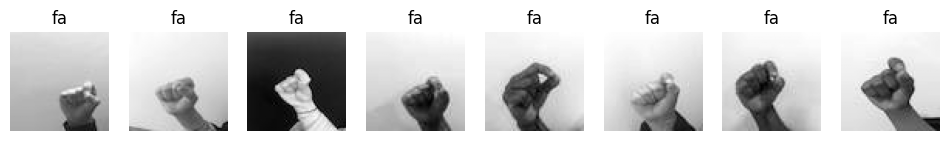

Final total images after cleaning: 48422


In [18]:
classes_clean = sorted([d for d in CLEAN_DIR.iterdir() if d.is_dir()], key=lambda p: p.name)
if classes_clean:
    sample_class = random.choice(classes_clean)
    sample_images = list(sample_class.glob("*.png"))[:8]

    if sample_images:
        plt.figure(figsize=(12, 3))
        for i, img_path in enumerate(sample_images, 1):
            img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
            plt.subplot(1, len(sample_images), i)
            plt.imshow(img, cmap="gray")
            plt.title(sample_class.name)
            plt.axis("off")
        plt.show()
print("Final total images after cleaning:", total_clean)